# Project Overview
You are tasked with predicting customer churn (whether a customer will leave or stay) using a variety of features. We'll implement the decision tree model, evaluate its performance, and address overfitting/underfitting using pruning and hyperparameter tuning.

#### Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import plot_tree

In [12]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 0. Preliminary EDA

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000
customerID           object
gender               object
SeniorCitizen      

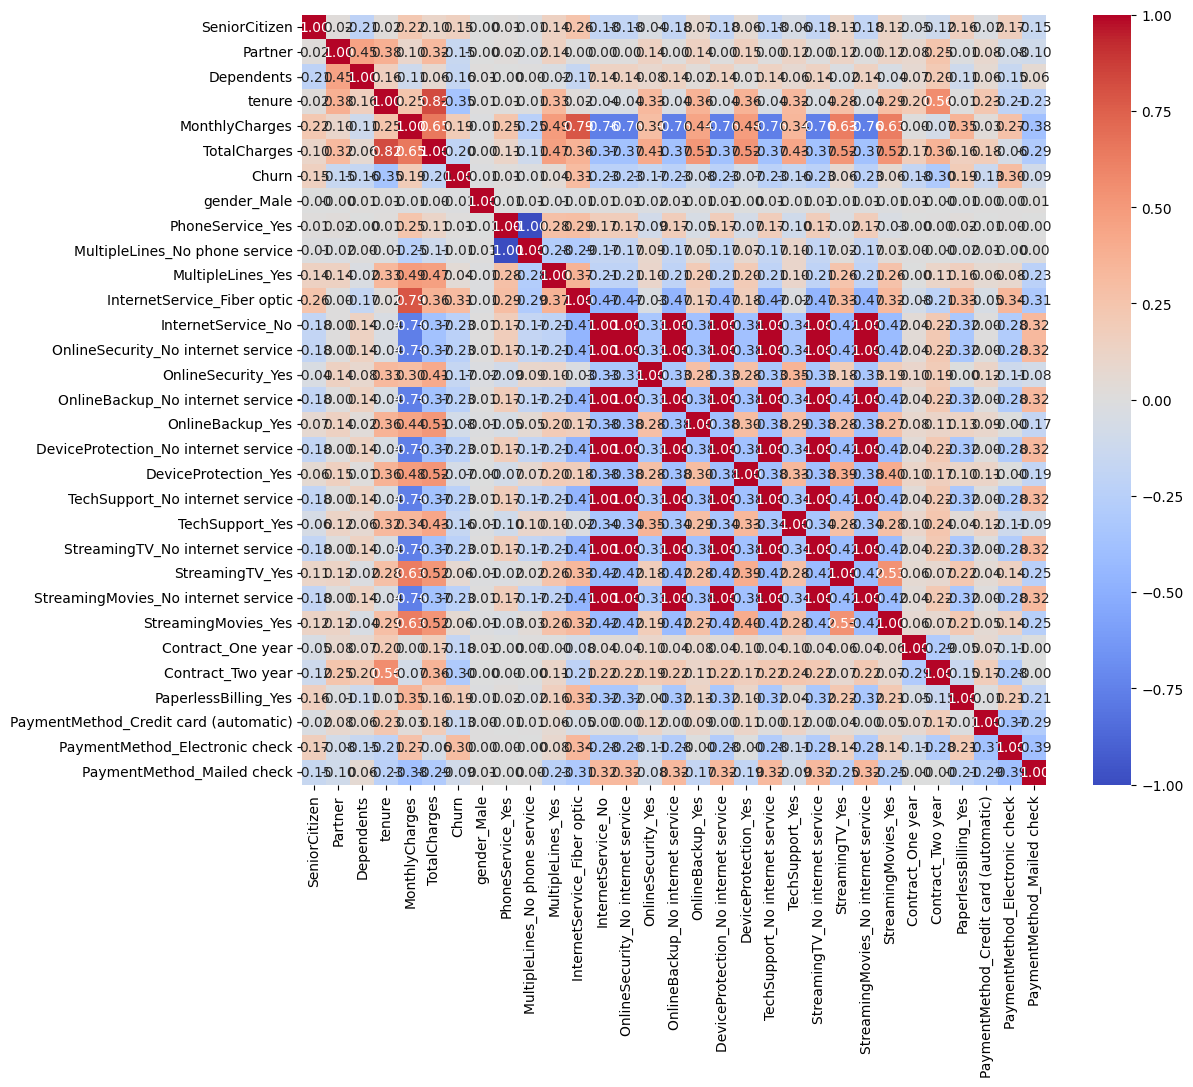

In [13]:
# Check for missing values
print(df.isnull().sum())

# Summary statistics for numerical columns
print(df.describe())

# Check for data types
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

# Exclude non-numeric columns (e.g., CustomerID, Churn, etc.) from numerical operations
df_cleaned = df.drop(columns=['customerID'])

# Identify numerical columns (you can also use df.select_dtypes() if needed)
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Identify categorical columns (object, category)
categorical_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns

# Impute missing values with the mean for numerical columns
df_cleaned[numerical_columns] = df_cleaned[numerical_columns].fillna(df_cleaned[numerical_columns].mean())
# Impute missing values for categorical columns with the mode (most frequent value)
for column in categorical_columns:
    mode_value = df_cleaned[column].mode()[0]  # Get the most frequent value
    df_cleaned[column] = df_cleaned[column].fillna(mode_value)
    
# Convert 'TotalCharges' to numeric (force errors to NaN)
df_cleaned['TotalCharges'] = pd.to_numeric(df_cleaned['TotalCharges'], errors='coerce')

# Refill any NaN values in 'TotalCharges' (if any)
df_cleaned['TotalCharges'] = df_cleaned['TotalCharges'].fillna(df_cleaned['TotalCharges'].mean())


# Binary categorical variables (e.g., 'SeniorCitizen', 'Partner', 'Churn')
label_encoder = LabelEncoder()

df_cleaned['SeniorCitizen'] = label_encoder.fit_transform(df_cleaned['SeniorCitizen'])
df_cleaned['Partner'] = label_encoder.fit_transform(df_cleaned['Partner'])
df_cleaned['Dependents'] = label_encoder.fit_transform(df_cleaned['Dependents'])
df_cleaned['Churn'] = label_encoder.fit_transform(df_cleaned['Churn'])

# One-Hot Encoding for multi-category variables (e.g., 'PaymentMethod', 'Contract')
df_cleaned = pd.get_dummies(df_cleaned, drop_first=True)

# Compute correlation matrix
corr_matrix = df_cleaned.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

# Scale the numerical features (standard scaling)
scaler = StandardScaler()
df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])

# Step-by-step Solution
## 1. Data Preparation

In [14]:
from sklearn.model_selection import train_test_split
# seperate features and target variables
X = df_cleaned.drop(columns=['Churn'])
y = df_cleaned['Churn']

# Split the data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

## 2. Initial Model Training and Evaluation

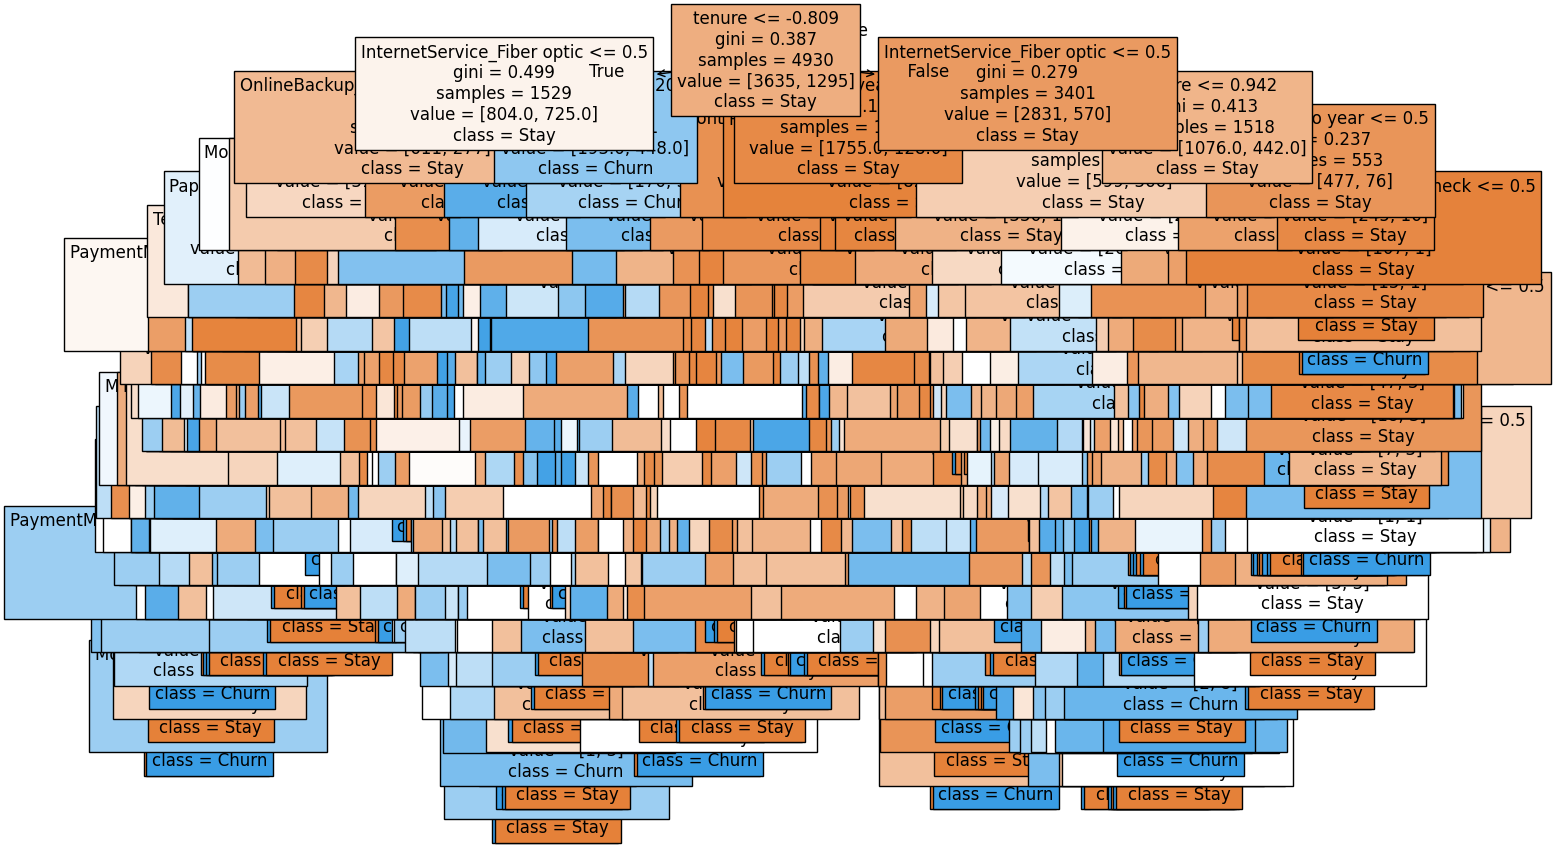

In [23]:
from sklearn.tree import plot_tree

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

plt.figure(figsize=(15,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Stay', 'Churn'], fontsize=12)
plt.title("Initial Decision Tree")
plt.show()

In [20]:
print(f"Train Accuracy; {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

Train Accuracy; 0.9983772819472616
Test Accuracy: 0.7397065783246569


## 3. Addressing Overfitting (Pruning the Tree)
### 3.1 Pre-pruning:
We can prune the tree before it grows too large by limiting the maximum depth, the minimum samples required to split a node, and the minimum samples required at a leaf.

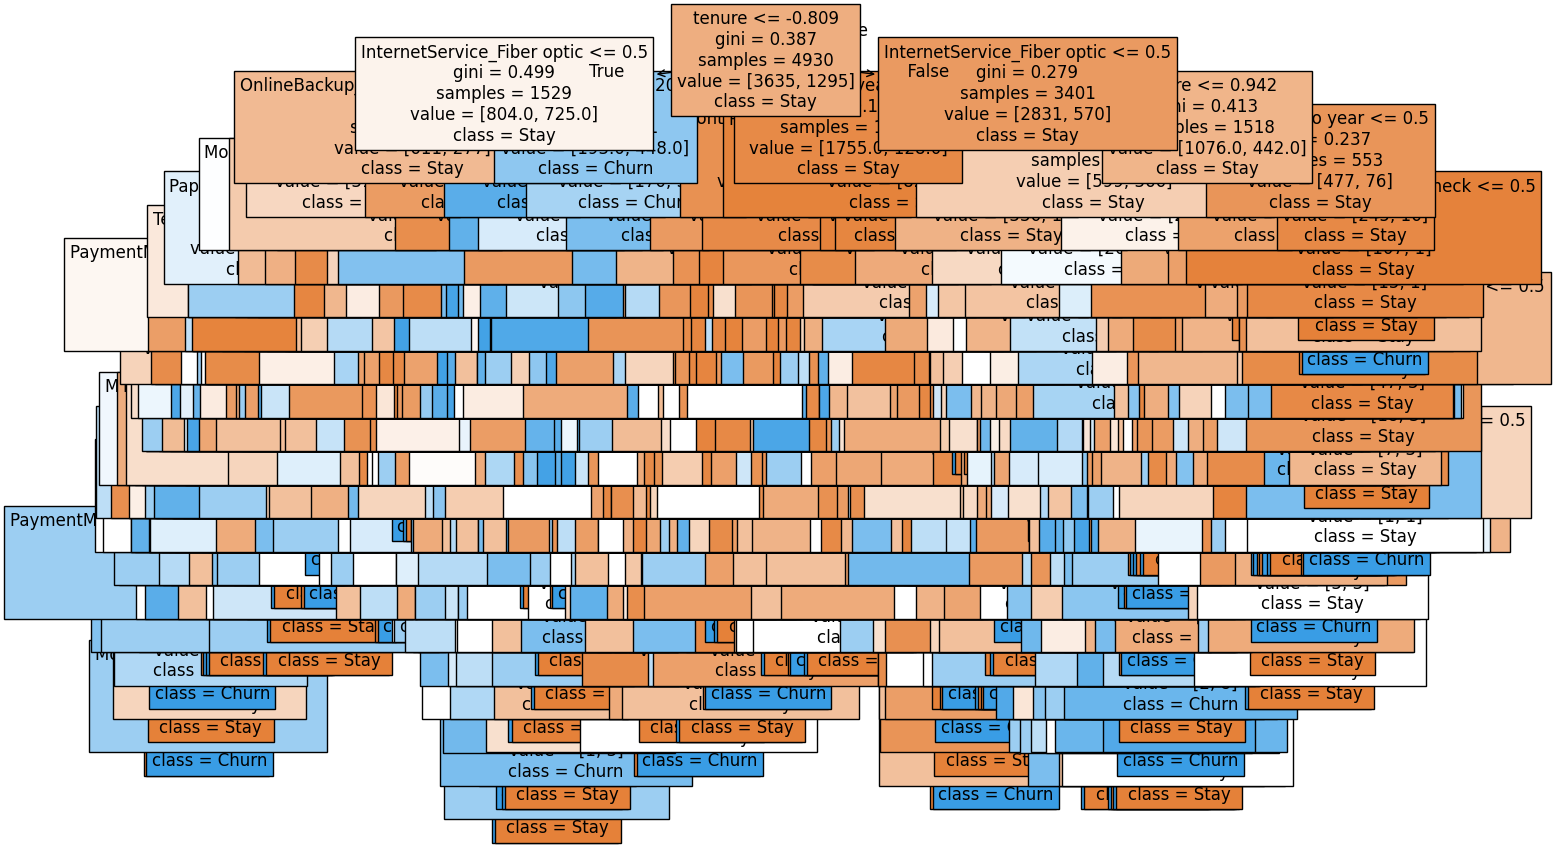

In [24]:
perpr_dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=4, )
perpr_dt_clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

plt.figure(figsize=(15,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Stay', 'Churn'], fontsize=12)
plt.title("Initial Decision Tree")
plt.show()

### 3.2 Post-pruning (Cost-Complexity Pruning):

Post-pruning involves growing the tree fully and then trimming it back based on the importance of each branch. In scikit-learn, this is done using cost-complexity pruning (ccp_alpha). Cost-complexity pruning is also known as weakest link pruning. Essentially, a decision tree is simplified by iteratively removing the node with least contribution to the model's accuracy. In other words, cutt-off the weakest-link in the tree so that complexity can be reduced while trying to maintain the predictive power.

#### Steps
- Calculate cost complexity.
    For each node in the tree, compute a cost complexity score (i.e., combination of the node's impurity like Gini index or entropy) and a pernalty term based on the number of leaves in the subtree rooted at that node using the following approach.
    - Calculate the impurity of each node. For a leaf node, the impurity is typically Gini index or entropy and for non-leaf nodes, it's the weighted impurity of its child nodes.
    - Count the number of leaf nodes for each subtree
    - Apply the complexity formula
   
   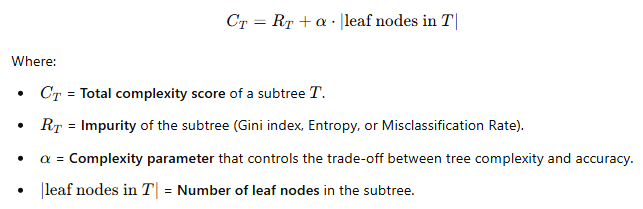
    
- Identify the weakest link.
    Find the node with the lowest cost complexity score i.e., weakest link.
- Prune the node.
    Remove the identified node and its children from the tree, replacing them with a leaf node.
- Repeat:
    Continue this process of identifying and pruning the node with the lowest complexity score until a stopping criteria is met or observing a significant drop in the performance on validation data

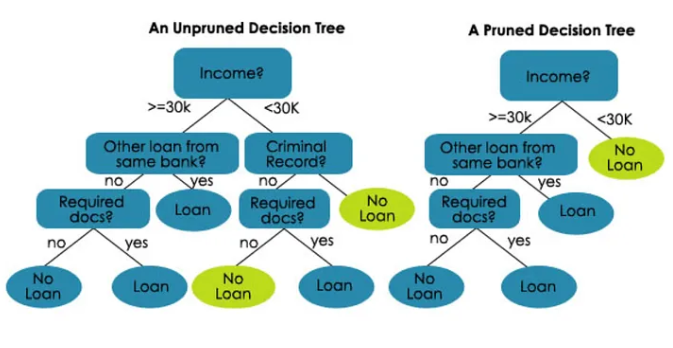

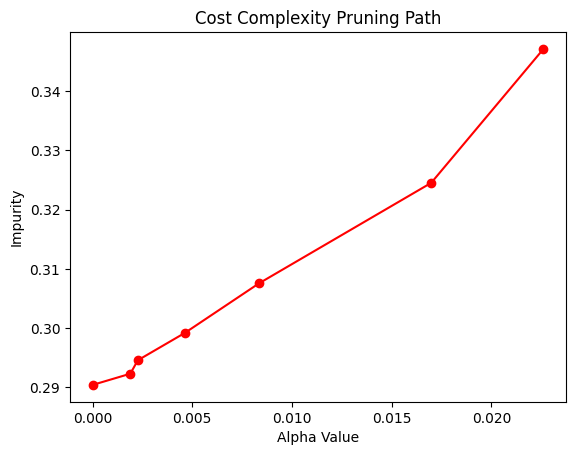

In [27]:
# compute effective alpha values and the corresponding impurities
path = perpr_dt_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]
impurities = path.impurities[:-1]

plt.plot(ccp_alphas, impurities, marker = 'o', color='r')
plt.title("Cost Complexity Pruning Path")
plt.xlabel("Alpha Value")
plt.ylabel("Impurity")
plt.show()

Train accuracy: 0.7918864097363083
Test accuracy: 0.7856128726928537


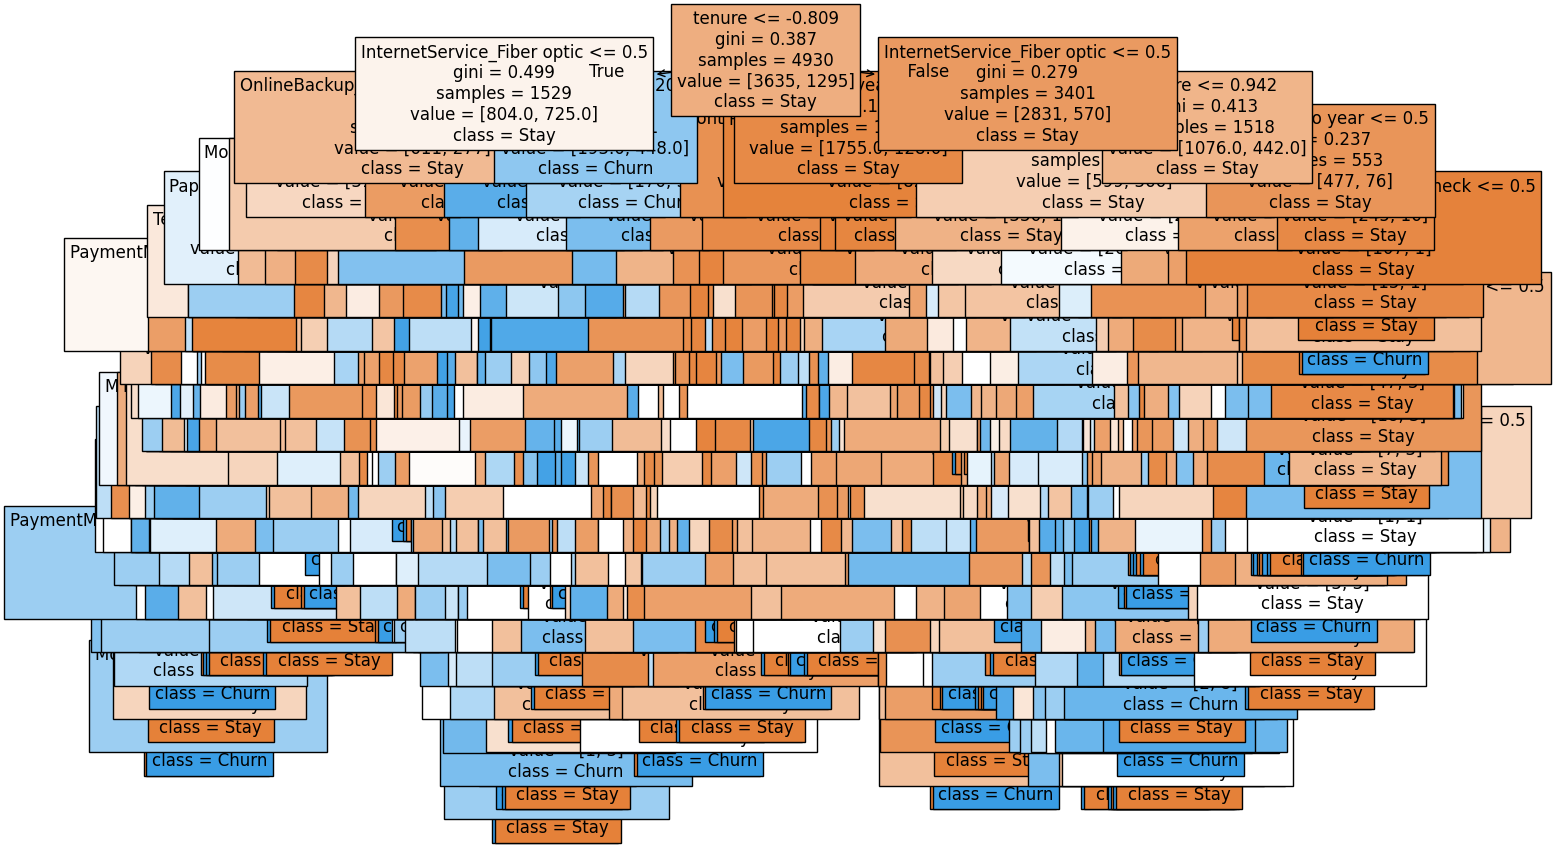

In [33]:
dt_trees = []
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    dt_trees.append(tree)
cv_scores = [cross_val_score(tree, X_train, y_train, cv=5).mean() for tree in dt_trees]

best_alpha = ccp_alphas[np.argmax(cv_scores)]
best_tree = dt_trees[np.argmax(cv_scores)]

y_pred_tr_bst = best_tree.predict(X_train)
y_pred_tt_bst = best_tree.predict(X_test)
accuracy_tr_bst = accuracy_score(y_train, y_pred_tr_bst)
accuracy_tt_bst = accuracy_score(y_test, y_pred_tt_bst)
print(f"Train accuracy: {accuracy_tr_bst}")
print(f"Test accuracy: {accuracy_tt_bst}")

plt.figure(figsize=(15,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Stay', 'Churn'], fontsize=12)
plt.title("Accuracy")
plt.show()


### 4. Hyperparameter Tuning Using Grid Search

C:\Users\lukec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'ccp_alpha': 0.001, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Train accuracy: 0.8042596348884381
Test accuracy: 0.7903454803596782


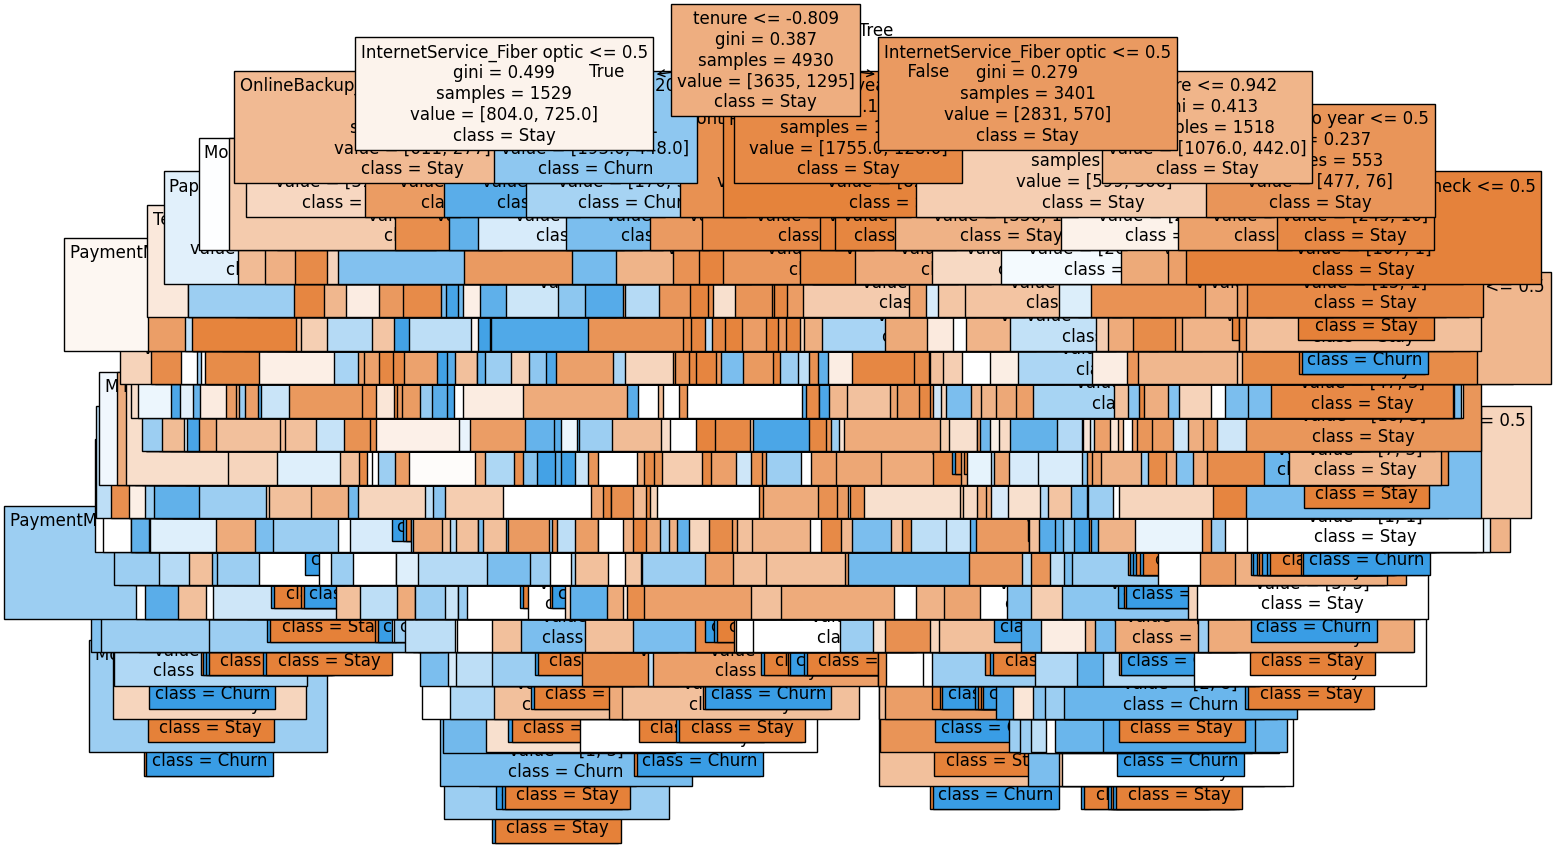

In [32]:
# define the parameter grid for tuning
param_grid = {
    'max_depth': [3,5,10,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'ccp_alpha':[0.0,0.001,0.01,best_alpha]
}

# Use those parameters for Grid search tp hypertune the parameters
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=1,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

best_clf = grid_search.best_estimator_
y_pred_tr_bst_gr = best_clf.predict(X_train)
y_pred_tt_bst_gr = best_clf.predict(X_test)

acc_tr_bst_gr = accuracy_score(y_train, y_pred_tr_bst_gr)
acc_tt_bst_gr = accuracy_score(y_test, y_pred_tt_bst_gr)
print(f"Train accuracy: {acc_tr_bst_gr}")
print(f"Test accuracy: {acc_tt_bst_gr}")

plt.figure(figsize=(15,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Stay', 'Churn'], fontsize=12)
plt.title("Hypertuned Decision Tree")
plt.show()

In [34]:
print(best_alpha)

0.0018935165106167828


### 5. Model Evaluation
After training the decision tree and pruning it, we evaluate its performance using several metrics:

- Accuracy
- Confusion Matrix
- Classification Report (Precision, Recall, F1-Score)
- ROC Curve & AUC

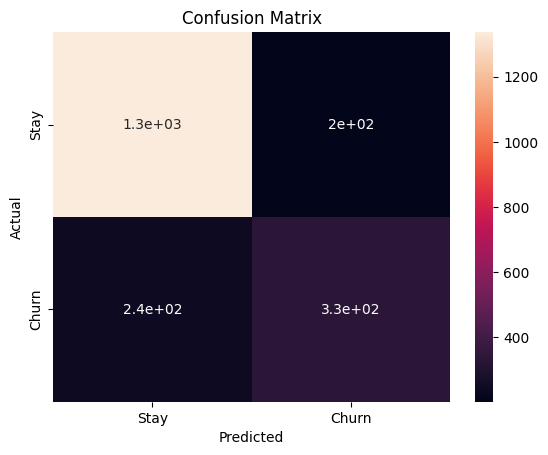

classification_report
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1539
           1       0.62      0.58      0.60       574

    accuracy                           0.79      2113
   macro avg       0.73      0.72      0.73      2113
weighted avg       0.79      0.79      0.79      2113



In [37]:
cm = confusion_matrix(y_test, y_pred_tt_bst_gr)
sns.heatmap(cm, annot=True, xticklabels=['Stay', 'Churn'], yticklabels=['Stay','Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("classification_report")
print(classification_report(y_test, y_pred_tt_bst_gr))

# Updated Approach with cross-validation


All the steps concerning loading the data, preliminary EDA and preprocessing are the same here. We are just concerned with the steps that might be treated differently concerning cross-validation technique.

## 2. Initial Decision Tree Model and Cross-Validation

## 3. Post-Pruning (Cost Complexity Pruning) with Cross-Validation

## 4. Hyperparameter Tuning using GridSearchCV with Cross-Validation

## 5. Final Model Evaluation (Cross-validation & ROC Curve)